# Superstore Sales: 2018 Goals and Forecast 

___

By: Alejandro Garcia and AJ Martinez
<br>
Date: April 22, 2022

___

## Project Goals

Given four years of sales data, identify sales patterns in order to produce a sales, and profit, forecast for 2018, and determine what courses of action will lead to increased sales in the future.

___

## Project Description

With growing demands in the market the VP of sales at a superstore giant has asked us, what should our sales goals for 2018 be? Given sales data for the years 2014 through 2017 the goal of this project is to determine what trends exist in the sales data that can help us determine what sales trends we can expect in 2018. Furthermore, we aim to discover where strengths, or weaknesses, exist in the sales numbers so that we can provide recommendations for improving sales, and profit, going forward.

___

## Importing the Required Modules

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn, sklearn, statsmodels, and prophet installed on your computer.

In [1]:
# We would like to ignore any warnings that may be provided by our libraries.

import warnings
warnings.filterwarnings("ignore")

In [12]:
# Here we are importing everything needed to execute the code blocks in this notebook.

from wrangle import *
from prepare import split_data
from explore import *
from model import *
from evaluate import append_eval_df, plot_forecast

___

## Data Acquisition and Preparation

The data is acquired from the MySQL database hosted at data.codeup.com. The database contains five tables and all five tables are selected.

The data is fairly clean, but some preparation is needed so that the data can be properly analyzed. A few columns are dropped since they are unuseful. Additionally, the order_date column is converted a datetime type and set as the index of the dataframe. There are no missing values in the data so no dropping or imputation is necessary.

The data spans four years, but not all dates are present in the data. The data needs to be downsampled (in our case it was downsampled to weeks) so that there are no gaps in the data. There are a few weeks not present in the data, but the number of missing weeks was minimal so we filled in those rows with zeroes.

Finally, for analysis the data is separated into multiple dataframes where one dataframe has total sales, four dataframes have sales by region, and three dataframes have sales by product category.

Additional code was created for removing outliers from the data so that we could analyze the data with and without outliers.

In [3]:
# Here we will acquire and prepare the superstore data. The wrangle function will also remove outliers and 
# it will return multiple dataframes. We only need the first one which is the total sales data.

dfs = wrangle_remove_outliers()
superstore = dfs[0]

Reading from .csv file.


___

## Exploratory Analysis

With the data prepared we can begin exploring the data to identify sales trends and points of strength, or weakness. The goal here is to determine what are the most consistent trends in the data that can give us an area to focus on for increasing sales and profit going forward.

In the visualizations below we aim to answer some questions about the data. Details about how these visualization are created can be found in the explore.py file.

### Is there seasonality in the data?

### Does the second half of the year have higher sales volume on average than the first half of the year?

### Are sales, and profit, numbers increasing over time?

### Do higher discounts typically result in greater losses?

Here we want to determine if there is a relationship between the discount feature and the profit feature in the data.

Reading from .csv file.


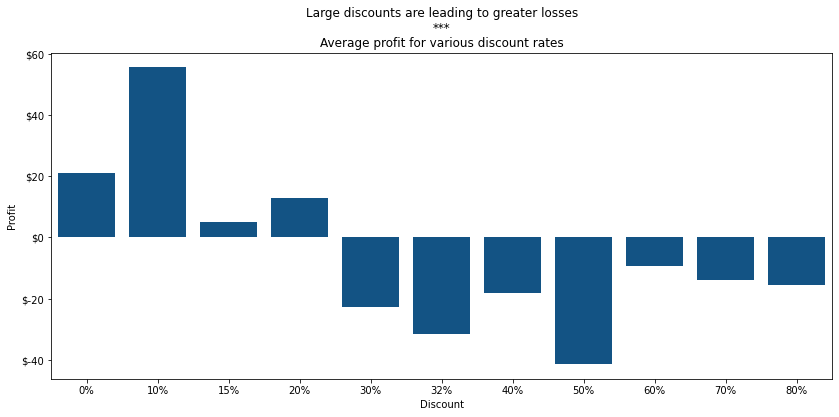

In [14]:
# Here we plot the average profit for each discount rate offered in the sales data.

plot_discount_and_profit()

We can see that beyond a 30% discount rate we consistently have losses on average. This would be expected with larger discount rates, but this affects does affect the bottom line. These sales with 30% or greater discounts account for 14% of all sales.

### Key Takeaways

___

## Modeling

Now we will build some forecasting models so that we can produce a sales and profit forecast for 2018. 

### Sales Forecast

Here we'll create our sales forecast for 2018. We will first need to split the data.

In [4]:
# Here we will split the data into train, validate, and test datasets. The data is split by year for convenience 
# where train is 2014-2015, validate is 2016, and test is 2017.

train, validate, test = split_data(superstore)

Next we must establish a baseline model to compare our models to.

In [5]:
# Here we will produce various static forecast models and choose the best one as the baseline. The produced are 
# last observed value, simple average, and various moving averages. The moving average periods used are 4 weeks,
# 12 weeks, 26 weeks, and 52 weeks.

evaluate_df = establish_baseline(train, validate, [4, 12, 26, 52])

Now we will make three different models to compare to the baseline and to each other and we'll choose the best one to evaluate on test. We will also use the best model to make the 2018 sales forecast. We use root mean squared error as our performance metric because we would like to know the average error our forecast has.

In [6]:
# Here we'll create all of our models and evalute each one on validate.
# The context manager suppresses the output from FB Prophet.

with suppress_stdout_stderr():
    evaluate_df = create_models('sales', train, validate, evaluate_df)
evaluate_df

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,model_type,target,rmse
0,Moving Average 26 Weeks,sales,685.0
1,Holt's Linear Trend,sales,3500.0
2,Prophet,sales,677.0
3,Previous Cycle,sales,872.0


We see here that Prophet had the best performance with an average error of 677. Let's now evaluate on test.

In [7]:
with suppress_stdout_stderr():
    predictions = prophet_model('sales', train, None, period = 365 * 3)
append_eval_df('Prophet', 'sales', test, predictions.loc['2017'])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,model_type,target,rmse
0,Prophet,sales,818.0


There is a drop off in performance which is concerning, but we'll have to just go forward with it. Now let's make a forecast for 2018.

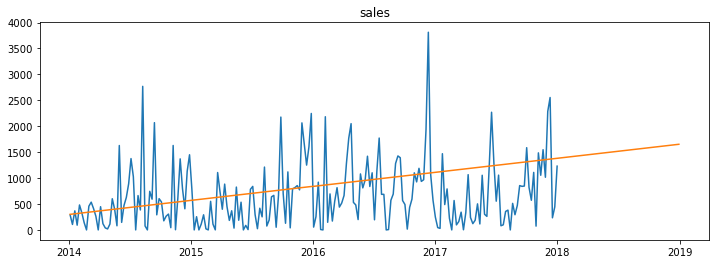

In [8]:
plot_forecast('sales', superstore, predictions.loc['2014' : '2018'])

It is now clear why the error is what it is. Due to the inconsistency in the data the best our forecast model can do is determine a straight line trend to fit the data. However, it does look like overall sales numbers are growing over time.

### Profit Forecast

Now we'll create our profit forecast. We'll take the same steps as we did for creating our sales forecast.

In [9]:
# We'll be performing all the same steps as above, but for brevity we'll use less code cells and assume
# that the reader already understands what is happening in each step.

evaluate_df = establish_baseline(train, validate, [4, 12, 26, 52], target = 'profit')

with suppress_stdout_stderr():
    evaluate_df = create_models('profit', train, validate, evaluate_df)
evaluate_df

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,model_type,target,rmse
0,Moving Average 12 Weeks,profit,173.0
1,Holt's Linear Trend,profit,173.0
2,Prophet,profit,174.0
3,Previous Cycle,profit,206.0


Here we had multiple models all with similar performance. Since we used the prophet model for the sales forecast we'll use the prophet model again here for profit.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


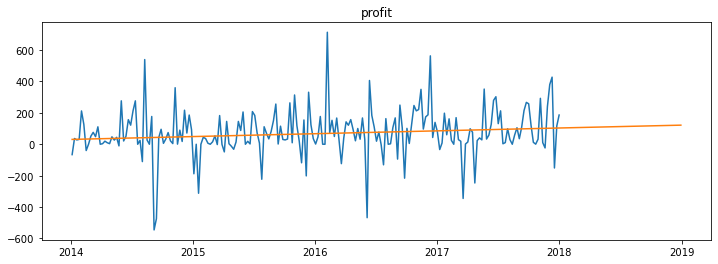

In [11]:
# Here we will make the profit forecast.

with suppress_stdout_stderr():
    predictions = prophet_model('profit', train, None, period = 365 * 3)
    
plot_forecast('profit', superstore, predictions.loc['2014' : '2018'])

We can see here that our model forecasts steadily increasing profit for 2018.

___

## Key Takeaways and Recommendations



___

## Next Steps